# 【双归一化网络】遍历匹配

* 【描述】作为双归一化网络的便利匹配

## 20230528log

* 【特性】加入EEnT支持


* 【使用】
    * 1 需要改变 "--arch" 参数，保证切片参数'--num_ele_slice'与预训练时一致
    * 2 更改预训练模型文件路径
    * 3 改变特征编码存储的文件路径


* 【注意】切片参数需要与与训练网络参数相同
    * 1 不仅"--arch"需要适配，切片参数'--num_ele_slice'也需要适配预训练的网络结构。
        * 如果没有适配，在加载模型中会出现missing key，需要注意
    * 2 使用的"--pretrained_weights" 预训练参数，需要与上一步存特征时一致，否则效果一定不好
    
## 20230604log

* 【特性】加入预计剩余时间eta（Estimated Time of Arrival）
* 【优化】推理时取消梯度保存，节约显存，提高速度

## 20230712log

* 【特性】在最后加入单次匹配，并输出相似度图、匹配区间，便于可视化输出

In [1]:
from Py01shared_code import AddPepperNoise, AddGaussianNoise, get_host_name_DINO_X, AddGaussianNoise_Pre_Snr, AddGaussianNoise_Pre, AddGaussianNoise_snr
from Py04Model_load import load_Pre_ViT_No1, get_args , dataset_from_geoTXT
from Py05_Matching_fun import idx2xy, xy2idx, idx_ex_range , dataset_from_geoTXT_aug_BiNorm, dataset_from_geoTXT_aug_BiNorm_BiAug, dataset_from_geoTXT_aug_BiNorm_BiAug_crop_and_padding, feature_normalize, minmaxscaler
from Py05_Matching_fun import dataset_from_geoTXT_aug_BiNorm_BiAug_Norm_first_then_mask, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_Resize
from Py06BiNet import load_Pre_BiNet_No1, get_global_norm, get_local_aug, load_Pre_BiNet_Res_NO1
from Py07EEnT import load_Pre_EEnT_tiny_No1
from Py08EEnT_NO2 import EEnT_NO2_tiny, load_Pre_EEnT_NO2_tiny
import Py10Bi_model
from Py11_Aug_self import MuskApply, MuskApply_tensor

In [2]:
import torch
import utils
import torch.distributed as dist
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms as pth_transforms
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import sys
import time

import random
import datetime

In [3]:
# 定义裁剪形状和步长
shape = (224, 224)
crop_shape = (224, 224)
out_shape = (224, 224)
stride = 1
mask_size = 224
pad_mode = "constant" # constant 为0填充、‘mean’——表示均值填充、‘median’——表示中位数
map_grid_path = "./Matching_map_raw/太平洋1_grid.pth"

In [4]:
stride_test = 20
rand_test_num = 1000

In [5]:
# 若对应不上编码的Matching_fea文件，可在下方手动指定save_file_path
t_prefix = datetime.date.today().strftime('%Y%m%d')
t_prefix = "20230625"
map_name = "太平洋1.txt"
# map_name = "大连海图数据.txt"
save_dir = "./Matching_fea/"
net_name = "【BiNet_Res_NO1】" + "_"
# mask_info = "mask_size" + str(mask_size) + "_"
mask_info = ""
addtion_info = "" +  "consPad" + "_"
host_name = get_host_name_DINO_X()

output_name = t_prefix + map_name[0:-4] + net_name + mask_info +  "fea_" + addtion_info + host_name + ".pth"# "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
save_file_path = save_dir + output_name
load_grid = True # 是否读取划分好的网格节省时间
print(save_file_path)

./Matching_fea/20230625太平洋1【BiNet_Res_NO1】_fea_consPad_DINO_3.pth


In [6]:
save_file_path = "./Matching_fea/太平洋1_GRET_ELE_DB_NO2_bi_fea.pth"
ex_range = 50# 匹配用的先验范围

args_self=[
# "--data_path","./Data_geo/Matching_test_high80/匹配test-high80",
# '--box_label_path',"./Data_geo/Matching_test_high80/【Label】匹配test-high80.csv",
# "--load_features","./dump_features", # 注释与否决定是否从文件加载特征
"--pretrained_weights", "./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth",
# "--pretrained_weights", "./checkpoint.pth",
# "--arch", "BiNet_NO1",
"--arch", "GRET_ELE_DB_NO2_bi", # 可选 BiNet_NO1、EEnT_tiny_NO1、EEnT_tiny_NO2, BiNet_Res_NO1, TBiNet_Res_NO2_bi
'--num_ele_slice', "20000",
]

args = get_args(args_self)


# 参数替换

* 如果从外部运行，且使用了其命名空间，可以通过检查某些变量是否存在来判断，是直接运行还是从外部运行

In [7]:
try:
    print("\r\n尝试读取外部变量：")
    print("pre_model_path_outside = " + str(pre_model_path_outside)) # 预训练权重
    # print("net_name_outside = " + str(net_name_outside)) # 网络名称
    print("arch_outside = " + str(arch_outside))
    print("save_file_path_outside = " + str(save_file_path_outside))
    print("map_grid_path_outside = " + str(map_grid_path_outside))
    print("shape_outside = " + str(shape_outside))
    print("stride_test_outside = " + str(stride_test_outside))
    print("crop_shape_outside = " + str(crop_shape_outside))
    print("ex_range_outside = " + str(ex_range_outside))
    print("num_ele_slice_outside = ", num_ele_slice_outside)
except NameError: # 外部定义变量不存在，使用本地，do noting
    print("外部变量不存在，使用【本地变量】")
#     var_exists = False
else: # 外部变量存在，使用外部：替换
    print("外部变量存在，使用【外部配置】")
    args.pretrained_weights = pre_model_path_outside
    args.arch = arch_outside
    # net_name = net_name_outside
    save_file_path = save_file_path_outside
    map_grid_path = map_grid_path_outside
    shape = shape_outside
    stride_test = stride_test_outside
    crop_shape = crop_shape_outside
    ex_range = ex_range_outside
    mask_size = mask_size_outside
    pad_mode = pad_mode_outside
    args.num_ele_slice = num_ele_slice_outside
#     var_exists = True


尝试读取外部变量：
外部变量不存在，使用【本地变量】


# 载入网格

In [8]:
x,y,z = torch.load(map_grid_path)
print("已存储网格载入成功")
# 定义裁剪形状和步长
global_min = z.min()
global_max = z.max()



已存储网格载入成功


In [9]:
n_rows = (z.shape[0] - shape[0]) // stride + 1
n_cols = (z.shape[1] - shape[1]) // stride + 1
n_matrices = n_rows * n_cols
# n_rows + 112
print(str((n_rows, n_cols, n_matrices)))

(1400, 1525, 2135000)


In [10]:
per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
per_li = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li = (per_li - global_min) / (global_max - global_min)
per_li[-1] = 1
print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li， 份数20000


In [11]:
per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
per_li_var = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li_var = (per_li_var - global_min) / (global_max - global_min)
per_li_var[-1] = 1
print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li_var， 份数20000


In [12]:
# per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
# per_li[-1] = 1
# print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
# # print(per_li)

In [13]:
# per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
# per_li_var[-1] = 1
# print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# # print(per_li)

# 加载预存储的特征向量

In [14]:
%%time
fea_vec_li = torch.load(save_file_path)
print("【预存储特征加载完成】\n嵌入维度为 " + str(fea_vec_li.shape[1]) +  "\n向量个数为：" + str(fea_vec_li.shape[0]))

【预存储特征加载完成】
嵌入维度为 195
向量个数为：2135000
CPU times: user 2.08 s, sys: 2.45 s, total: 4.53 s
Wall time: 4.55 s


In [15]:
try:
    utils.init_distributed_mode(args)
except:
    print("已经启动，不再重复")
    pass

Will run the code on one GPU.
| distributed init (rank 0): env://


# 数据集加载

In [16]:
# 初始的增强
# transform_for_match = pth_transforms.Compose([
# #     pth_transforms.Resize(256, interpolation=3),
# #     pth_transforms.CenterCrop(224),
#     pth_transforms.GaussianBlur(kernel_size = 21, sigma = 2),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])
# dataset_geo = dataset_from_geoTXT_aug_BiNorm(z, shape, stride, transform_for_match, global_min, global_max)

In [17]:
# 加旋转的测试增强
# transform_for_match = pth_transforms.Compose([
# #     pth_transforms.Resize(256, interpolation=3),
# #     pth_transforms.CenterCrop(224),
#     pth_transforms.GaussianBlur(kernel_size = 21, sigma = 2),
#     pth_transforms.RandomRotation((0, 1)),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])
# dataset_geo = dataset_from_geoTXT_aug_BiNorm(z, shape, stride, transform_for_match, global_min, global_max)

In [18]:
# # 改为高斯噪声的增强
# transform_for_match = pth_transforms.Compose([
# #     pth_transforms.Resize(256, interpolation=3),
# #     pth_transforms.CenterCrop(224),
# #     pth_transforms.GaussianBlur(kernel_size = 21, sigma = 2),
#     AddGaussianNoise(mean=0, variance=1, amplitude=10),
# #         AddGaussianNoise(mean=0, variance=1, amplitude=255),
# #     pth_transforms.RandomRotation((0, 10), expand=False),
# #     pth_transforms.Resize([224,224]),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# dataset_geo = dataset_from_geoTXT_aug_BiNorm(z, shape, stride, transform_for_match, global_min, global_max)

In [19]:
transform_for_match = pth_transforms.Compose([
    
#     AddGaussianNoise_snr(mean=0, variance=1, snr=( 1 - 0.04)),
#         AddGaussianNoise(mean=0, variance=1, amplitude=255),
    AddGaussianNoise(mean=0, variance=10, amplitude=1), # variance=gauss_no_outside
    # AddPepperNoise(snr = 0.999, p = 1.0),
    pth_transforms.RandomRotation((0, 10), expand=False), # Rotation先，出来的图是正的
    MuskApply(mask_size = mask_size, mode = pad_mode), # constant为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     pth_transforms.RandomRotation((0, 10), expand=False), # Rotation后，出来的图是有斜角的
#     pth_transforms.Resize([224,224]),
    
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485], std=[0.229]),
])

transform_for_global_match = pth_transforms.Compose([
    # MuskApply(mask_size = mask_size, mode=pad_mode),
    pth_transforms.CenterCrop(mask_size),
    pth_transforms.ToTensor(),
])
dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug(z, shape, stride, transform_for_match, transform_for_global_match, global_min, global_max)

In [20]:
# # 测试：【实验1】：先裁剪再做归一化、padding
# transform_for_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_crop_and_padding(z, (20,20), (224,224), stride, transform_for_match, transform_for_global_match, global_min, global_max)

In [21]:
# # 【实验2】：先归一化，再mask
# transform_for_match = pth_transforms.Compose([
#     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数

#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
#     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Norm_first_then_mask(z, (20,20), (224,224), stride, transform_for_match, transform_for_global_match, global_min, global_max)

In [22]:
# # 【实验3】：先norm，再mask，保持padding为0
# transform_for_match = pth_transforms.Compose([
#     AddGaussianNoise(mean=0, variance=1, amplitude=10),
# #     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
#     MuskApply_tensor(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
    
# ])

# transform_for_global_match = pth_transforms.Compose([
    
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     pth_transforms.ToTensor(),
    
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Norm_first_then_mask(z, (20,20), (224,224), stride, transform_for_match, transform_for_global_match, global_min, global_max)

In [23]:
# # 【测试5】在转为图像之前，就加入高斯噪声。（仍为图像方案，可能会损失精度，实验目的只是测试统一信噪比增强，对小尺寸与大尺寸上，会不会有理想的结果）
# # Gauss_aug_Obj = AddGaussianNoise_Pre_Snr(mean=0, variance=1, snr=0.99)
# Gauss_aug_Obj = AddGaussianNoise_Pre(mean=0, variance=1, amplitude=5)
# transform_for_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug(z, crop_shape, (224,224), stride, Gauss_aug_Obj, transform_for_match, transform_for_global_match, global_min, global_max)

In [24]:
# # 【测试6】彻底不使用图像化增强
# # Gauss_aug_Obj = AddGaussianNoise_Pre_Snr(mean=0, variance=1, snr=0.99)
# Gauss_aug_Obj = AddGaussianNoise_Pre(mean=0, variance=2, amplitude=5)
# transform_for_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode_outside),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG(z, crop_shape, (224,224), stride, Gauss_aug_Obj, transform_for_match, transform_for_global_match, global_min, global_max)

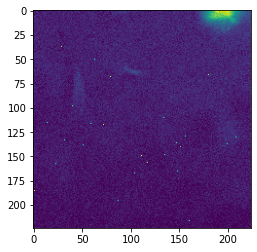

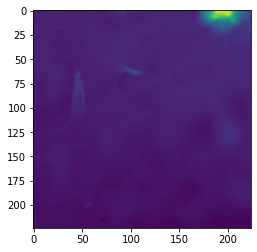

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
普通归一化与全局归一化图像


In [25]:
data,data_global_norm,_,_ = dataset_geo.__getitem__(1000)
plt.imshow(data.squeeze())
plt.show()
plt.imshow(data_global_norm.squeeze())
plt.show()
print(data.shape)
print(data_global_norm.shape)
print("普通归一化与全局归一化图像")

全局归一化图像


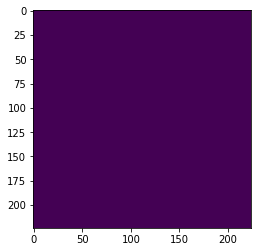

In [26]:
# 全局归一化
# def get_global_norm(data):
#     data_global_norm = (data - global_min) / (global_max - global_min)
#     # 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
#     data_global_norm[0] = 0
#     data_global_norm[-1]  = 1
#     return data_global_norm

# 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
data_global_norm[0] = 0
data_global_norm[-1]  = 1
plt.imshow(data_global_norm.squeeze())
print("全局归一化图像")

In [27]:
# 获取bof特征
load_bof_voc = True
if load_bof_voc:
    bof_voc, bof_stdSlr = torch.load("./bof_voc/voc_Pacific.pth")
    voc_k = bof_voc.shape[0]
    print("voc_k = ", voc_k, " (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)")
    print("成功加载bof_voc")
else:
    voc_k = 100
    bof_voc, bof_stdSlr = get_bof_Pacific_voc(dataset_geo, using_num = 2000, voc_k = voc_k)
    torch.save((bof_voc, bof_stdSlr), "./bof_voc/voc_Pacific.pth")

voc_k =  100  (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)
成功加载bof_voc


# 加载预训练模型

* 注意，这里加载的预训练模型需要与编码预存储的一致，例如使用【Try4】预训练模型

In [28]:
%%time
assert os.path.exists(args.pretrained_weights), "权重不存在，检查路径"

if args.arch == "BiNet_NO1":
    model = load_Pre_BiNet_No1(args)
elif args.arch == "EEnT_tiny_NO1": 
    model = load_Pre_EEnT_tiny_No1(args)
elif args.arch == "EEnT_tiny_NO2":
    model = load_Pre_EEnT_NO2_tiny(args, per_li = per_li)
    embed_dim = model.embed_dim
elif args.arch == "BiNet_Res_NO1":
    model = load_Pre_BiNet_Res_NO1(args)
    embed_dim = model.embed_dim
elif args.arch in Py10Bi_model.__dict__.keys():
    try:
        model = Py10Bi_model.__dict__[args.arch]() # 调用函数
        print("模型" + args.arch + "创建成功")
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
    except:
        model = Py10Bi_model.__dict__[args.arch](num_ele_slice=args.num_ele_slice, per_li=per_li, per_li_var=per_li_var,
                                           bof_voc=bof_voc, bof_stdSlr=bof_stdSlr, in_chans=1, voc_k = voc_k,
                                          g_min = global_min, g_max = global_max)
        embed_dim = model.embed_dim
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
else:
    assert 0, "不支持的模型"
    
# utils.init_distributed_mode(args)
print("【完成】使用预训练模型：" + str(args.pretrained_weights))
print("【完成】计算节点(process group)启动完成")

Take key teacher in provided checkpoint dict
Pretrained weights found at ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
预训练模型加载成功
【完成】使用预训练模型：./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth
【完成】计算节点(process group)启动完成
CPU times: user 10.8 s, sys: 19.1 s, total: 29.9 s
Wall time: 3.56 s


# 单个点遍历匹配测试

In [29]:
def matching_iter(output_vec, search_range_li):
    pre_index = -1
    min_dis = 100000
    pdist = torch.nn.PairwiseDistance(p=2)
#     pdist = DINOLoss_for_Matching(out_dim = 192).cuda()

    for i in search_range_li:
        dis = pdist(output_vec, fea_vec_li[i, :].unsqueeze(0))
#         similarity = torch.cosine_similarity(output_vec.squeeze(), fea_vec_li[i, :], dim=0)
        if dis < min_dis:
            min_dis = dis
            pre_index = i
    return pre_index, min_dis

In [30]:
def distance_point(box1, box2):
    x_dis = math.pow((box1[0] - box2[0]), 2)
    y_dis = math.pow((box1[1] - box2[1]), 2)
    return math.sqrt(x_dis + y_dis)

In [31]:
## 未使用
# class DINOLoss_for_Matching(nn.Module):
#     def __init__(self, out_dim, student_temp=0.1,
#                  center_momentum=0.9):
#         super().__init__()
#         self.student_temp = student_temp
#         self.center_momentum = center_momentum

#     def forward(self, student_output, teacher_output):
#         """
#         Cross-entropy between softmax outputs of the teacher and student networks.
#         """
#         student_out = student_output # / self.student_temp
#         teacher_out = F.softmax((teacher_output), dim=-1)
#         loss = torch.sum(-teacher_out * F.log_softmax(student_out, dim=-1), dim=-1)
#         return loss
        
# dino_loss_for_matching = DINOLoss_for_Matching(out_dim = 192).cuda()
# # data1 = torch.rand([1,192]).cuda()
# # dino_loss_for_matching(data1,data1)

In [45]:
# %%time
rand_idx = int(torch.rand([1], dtype=torch.float32) * len(dataset_geo))
# rand_idx = 5872663
print("测试序号:" + str(rand_idx))

data, data_global_norm, index, box =  dataset_geo.__getitem__(rand_idx)
# samples = samples.unsqueeze(0).cuda()
# data_global_norm = get_global_norm(samples)
# data = get_local_aug(samples)
data = data.unsqueeze(0).cuda(non_blocking=True)
data_global_norm = data_global_norm.unsqueeze(0).cuda(non_blocking=True)
output_vec = model(data, data_global_norm)
print("输出向量尺寸：" + str(output_vec.shape))

range_li = idx_ex_range(index, ex_range, n_rows, n_cols)
len(range_li)

pre_index, min_dis = matching_iter(output_vec, range_li)

# 计算像素偏差
center_Truth = idx2xy(index, n_rows, n_cols)
center_Pred  = idx2xy(pre_index, n_rows, n_cols)
grid_bias = distance_point(center_Truth, center_Pred)

print("匹配预测id为： " + str(pre_index))
print("真实标签id为： " + str(int(index)))
print("最小特征距离为：" + "{:.3f}".format(float(min_dis))) 
print("网格偏差距离：" + "{:.3f}".format(grid_bias))

测试序号:1355266
输出向量尺寸：torch.Size([1, 195])
匹配预测id为： 1355266
真实标签id为： 1355266
最小特征距离为：0.102
网格偏差距离：0.000


# 随机rand_test_num个匹配（时间短）

In [ ]:
def print_result(file = sys.stdout):
    print("总时长: " + str(total_time) + " s", file = file)
    print("测试时的增强："+ str(transform_for_match), file = file)
    print("测试时的全局增强："+ str(transform_for_global_match), file = file)
    try:
        print(Gauss_aug_Obj, file = file)
    except:
        pass
    print("测试地图：" + str(map_grid_path), file = file)
    print("随机测试数量：" + str(rand_test_num), file = file)
    print("crop_shape：" + str(crop_shape), file = file)
#     print("输入尺寸（网络）：" + str(out_shape), file = file)
    print("地图尺寸：" + str(z.shape), file = file)
#     print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test), file = file)
#     print("步长stride_test  =" + str(stride_test), file = file)
    print("save_file_path = " + str(save_file_path), file = file)
    print("pretrained_weights = " + str(args.pretrained_weights), file = file)
    print("num_ele_slice = " + str(args.num_ele_slice), file = file)
    print("arch = " + str(args.arch), file = file)
    print("先验范围 = " + str(ex_range), file = file)
    print("平均偏差 = " + "{:.5f}".format(avg_bias) + " grid", file = file)
    print("ACC_" + str(a) + " = " + "{:.2f}".format(acc_a*100) + "%", file = file)
    print("ACC_" + str(b) + " = " + "{:.2f}".format(acc_b*100) + "%", file = file)
    print("ACC_" + str(c) + " = " + "{:.2f}".format(acc_c*100) + "%", file = file)
    print("特征平均距离" + "{:.2f}".format(float(avg_Fea_Distance)), file = file)
    print("【ACC_li】从0-20 (step 0.5) 的偏差 " + str(Acc_li), file = file)

In [ ]:
def write_to_temp(lines):
    with open('【临时】temp_log.txt', 'w') as f:
#         f = open('temp_log.txt', 'w')
        f.writelines(lines)
        f.close()

In [ ]:
# 
a = 1 # 距离小于1个的准确率
b = 3
c = 10
ACC_range = 41

Acc_cnt_a  = 0
Acc_cnt_b  = 0
Acc_cnt_c  = 0
Acc_li = [0] * ACC_range

Bias_all = 0
dis_fea_all = 0
pdist = torch.nn.PairwiseDistance(p=2)
# t = tqdm(, ncols=80)
time_last = time.time()
# range_li = [i for i in range(dataset_geo.__len__())] # 获取先验范围
dataset_len = dataset_geo.__len__()
print("\r\n\r\n【少量随机匹配测试】测试数量：" + str(rand_test_num) )
select_li = np.random.choice(dataset_len, rand_test_num, replace=False)
select_li = [int(item) for item in select_li] # 转为list
# print(select_li)
start_time = time.time()
for i, idx in enumerate(select_li): # 遍历匹配
    torch.cuda.empty_cache()
    interval = time.time() - time_last
    time_last = time.time()
    eta = interval * (rand_test_num - i )
    acc1_now = Acc_li[2] / (i+1) * 100
    str_log = "Processcing num: [" + str(i) +"/" + str(rand_test_num) + "] "  + " Acc1_now=" + "{:0.2f}".format(acc1_now) + "% eta:" + str(int(eta//60))+ ":" + "{:02d}".format(int(eta%60)) + "          "
    print(str_log, end = '\r')
    write_to_temp(["Running 【NB16】small匹配中……\n", str_log])

#     start_i = i * stride_test
#     start_j = j * stride_test
#     # 计算中心点坐标
#     center_i = start_i + shape[0] // 2
#     center_j = start_j + shape[1] // 2
#     # 转换为1步长的idx，便于检索
#     idx_real = xy2idx(center_i, center_j, n_rows, n_cols, shape = crop_shape)
    # 对待匹配区域编码
    samples, samples_global_norm, index, box =  dataset_geo.__getitem__(idx)

    samples = samples.cuda().unsqueeze(0)
    samples_global_norm = samples_global_norm.cuda().unsqueeze(0)
    with torch.no_grad():
        output_vec = model(samples, samples_global_norm)
    # 匹配
#     index_ground     = dataset_geo.available_idx_li[index] # 获取idx_ground
    range_li = idx_ex_range(index, ex_range, n_rows, n_cols, shape = crop_shape) # 获取先验范围
    pre_index, min_fea_dis = matching_iter(output_vec, range_li)
#     pre_index_ground = dataset_geo.available_idx_li[pre_index] # 覆盖为idx_ground
#     pre_index[]
#     print("index=" + str(index))
#     print("pre_index=" + str(pre_index))
    # 计算像素偏差
#     center_Truth = idx2xy(index, n_rows, n_cols, shape = (224,224))
#     center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = (224,224))
    center_Truth = idx2xy(index, n_rows, n_cols, shape = crop_shape)
    center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = crop_shape)
    grid_bias = distance_point(center_Truth, center_Pred)
    # 计算特征偏差
    dis = pdist(output_vec, fea_vec_li[index, :].unsqueeze(0))
    for k in range(ACC_range):
        if grid_bias <= k / 2:
            Acc_li[k] += 1
    if grid_bias <= a: # 完全匹配计数
        Acc_cnt_a += 1
    if grid_bias <= b: # 完全匹配计数
        Acc_cnt_b += 1
    if grid_bias <= c: # 完全匹配计数
        Acc_cnt_c += 1 
    Bias_all += grid_bias
    dis_fea_all += dis
end_time = time.time()
total_time = end_time - start_time
print("\n处理完成")
avg_bias = Bias_all / rand_test_num
acc_a = Acc_cnt_a / rand_test_num
acc_b = Acc_cnt_b / rand_test_num
acc_c = Acc_cnt_c / rand_test_num
Acc_li = [acc / rand_test_num for acc in Acc_li]

avg_Fea_Distance = dis_fea_all / rand_test_num

print_result() # 默认参数打印到屏幕

log_file = open("【输出】NB16_match_result_temp_Small_Edition.txt", 'w')
print_result(file=log_file) # 重定向到文件
log_file.close()

In [ ]:
assert 0 # 只需要运行1000个就行

# 挑部分点匹配与匹配评估

In [30]:
shape = (224, 224)
# stride_test = 30 # 100, 30, 224
# ex_range = 50 # 先验范围

n_rows_test = (z.shape[0] - shape[0]) // stride_test + 1
n_cols_test = (z.shape[1] - shape[1]) // stride_test + 1
n_matrices_test = n_rows_test * n_cols_test
# n_rows + 112
print(str((n_rows_test, n_cols_test, n_matrices_test)))

(47, 51, 2397)


In [31]:
def print_result(file = sys.stdout):
    print("总时长: " + str(total_time) + " s", file = file)
    print("测试时的增强："+ str(transform_for_match), file = file)
    print("测试时的全局增强："+ str(transform_for_global_match), file = file)
    try:
        print(Gauss_aug_Obj, file = file)
    except:
        pass
    print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test), file = file)
    print("crop_shape = " + str(crop_shape), file = file)
    print("步长stride_test  =" + str(stride_test), file = file)
    print("save_file_path = " + str(save_file_path), file = file)
    print("pretrained_weights = " + str(args.pretrained_weights), file = file)
    print("num_ele_slice = " + str(args.num_ele_slice), file = file)
    print("arch = " + str(args.arch), file = file)
    print("先验范围 = " + str(ex_range), file = file)
    print("平均偏差 = " + "{:.5f}".format(avg_bias) + " grid", file = file)
    print("ACC_" + str(a) + " = " + "{:.2f}".format(acc_a*100) + "%", file = file)
    print("ACC_" + str(b) + " = " + "{:.2f}".format(acc_b*100) + "%", file = file)
    print("ACC_" + str(c) + " = " + "{:.2f}".format(acc_c*100) + "%", file = file)
    print("特征平均距离" + "{:.2f}".format(float(avg_Fea_Distance)), file = file)
    print("【ACC_li】从0-20 (step 0.5) 的偏差 " + str(Acc_li), file = file)

In [32]:
def write_to_temp(lines):
    with open('【临时】temp_log.txt', 'w') as f:
#         f = open('temp_log.txt', 'w')
        f.writelines(lines)
        f.close()

In [33]:
# 
a = 1 # 距离小于1个的准确率
b = 3
c = 10
ACC_range = 41

Acc_cnt_a  = 0
Acc_cnt_b  = 0
Acc_cnt_c  = 0
Acc_li = [0] * ACC_range

Bias_all = 0
dis_fea_all = 0
pdist = torch.nn.PairwiseDistance(p=2)
# t = tqdm(, ncols=80)
time_last = time.time()
start_time = time.time()
print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test))
for i in range(n_rows_test):
    for j in range(n_cols_test):
        torch.cuda.empty_cache()
        interval = time.time() - time_last
        time_last = time.time()
        eta = interval * (n_cols_test * n_rows_test - i * n_cols_test - j)
        acc1_now = Acc_li[2] / (i*n_cols_test + j + 1) * 100
        str_log = "Processcing num: [" + str(i*n_cols_test+j) +"/" + str(n_matrices_test) + "] "  + " Acc1_now=" + "{:0.2f}".format(acc1_now) + "% eta:" + str(int(eta//60))+ ":" + "{:02d}".format(int(eta%60)) + "          "
        print(str_log, end = '\r')
        write_to_temp(["Running 【NB16】匹配中……\n", str_log])
        
        start_i = i * stride_test
        start_j = j * stride_test
        # 计算中心点坐标
        center_i = start_i + shape[0] // 2
        center_j = start_j + shape[1] // 2
        # 转换为1步长的idx，便于检索
        idx_real = xy2idx(center_i, center_j, n_rows, n_cols)
        # 对待匹配区域编码
        samples, samples_global_norm, index, box =  dataset_geo.__getitem__(idx_real)

        samples = samples.cuda().unsqueeze(0)
        samples_global_norm = samples_global_norm.cuda().unsqueeze(0)
        with torch.no_grad():
            output_vec = model(samples, samples_global_norm)
        # 匹配
        range_li = idx_ex_range(index, ex_range, n_rows, n_cols) # 获取先验范围
        pre_index, min_fea_dis = matching_iter(output_vec, range_li)
        
        # 计算像素偏差
        center_Truth = idx2xy(index, n_rows, n_cols)
        center_Pred  = idx2xy(pre_index, n_rows, n_cols)
        grid_bias = distance_point(center_Truth, center_Pred)
        # 计算特征偏差
        dis = pdist(output_vec, fea_vec_li[index, :].unsqueeze(0))
        for k in range(ACC_range):
            if grid_bias <= k / 2:
                Acc_li[k] += 1
        if grid_bias <= a: # 完全匹配计数
            Acc_cnt_a += 1
        if grid_bias <= b: # 完全匹配计数
            Acc_cnt_b += 1
        if grid_bias <= c: # 完全匹配计数
            Acc_cnt_c += 1 
        Bias_all += grid_bias
        dis_fea_all += dis
end_time = time.time()
total_time = end_time - start_time
print("\n处理完成")
avg_bias = Bias_all / n_matrices_test
acc_a = Acc_cnt_a / n_matrices_test
acc_b = Acc_cnt_b / n_matrices_test
acc_c = Acc_cnt_c / n_matrices_test
Acc_li = [acc / n_matrices_test for acc in Acc_li]

avg_Fea_Distance = dis_fea_all / n_matrices_test

print_result() # 默认参数打印到屏幕

log_file = open("【输出】NB16_match_result_temp.txt", 'w')
print_result(file=log_file) # 重定向到文件
log_file.close()

测试数量：47*51 = 2397


IndexError: index 3050 is out of bounds for dimension 0 with size 2999

In [ ]:
assert 0

# 单次匹配，并输出相似度图、匹配区间

In [467]:
from bisect import bisect_left

In [628]:
def matching_iter_for_simiPic(output_vec, search_range_li, ex_range, n_rows, n_cols, crop_shape):
    pre_index = search_range_li[0]
    min_dis = np.inf
    pdist = torch.nn.PairwiseDistance(p=2)
#     pdist = DINOLoss_for_Matching(out_dim = 192).cuda()
    dis_li = torch.zeros([len(search_range_li)], dtype=torch.float32)
    for i, idx in enumerate(search_range_li):
        print("匹配进度[{:5d}\{:5d}]".format(i, len(search_range_li)), end = "\r")
        dis = pdist(output_vec, fea_vec_li[idx, :].unsqueeze(0))
#         similarity = torch.cosine_similarity(output_vec.squeeze(), fea_vec_li[i, :], dim=0)
        dis_li[i] = dis
        if dis < min_dis:
            min_dis = dis
            pre_index = idx
    # 将匹配到的号转为坐标
    center_Pred = idx2xy(pre_index, n_rows, n_cols)
    # 相关度list重排为矩阵
    size = ex_range*2+crop_shape[0]
    dis_array = torch.zeros([size, size], dtype = torch.float32)
    x_min, y_min = idx2xy(search_range_li[0], n_rows, n_cols)
#     dis_li = dis_li.numpy
    dis_li = (dis_li - dis_li.mean()) / dis_li.var()
#     print(dis_li)
    dis_li = (dis_li - dis_li.min()) / (dis_li.max() - dis_li.min())
    dis_li = [torch.exp((-d+dis_li.max()) * 10) for d in dis_li] # 变为非0的归一化后的值

    for i, idx in enumerate(search_range_li):
        x_real, y_real = idx2xy(idx, n_rows, n_cols)
        x_array = x_real - x_min  + crop_shape[0] // 2
        y_array = y_real - y_min  + crop_shape[0] // 2
        dis_array[x_array, y_array] = dis_li[i]
    
    # 获取范围内的数据图range_data_array
    range_data_array = torch.zeros([size, size], dtype = torch.float32)
    x_min, y_min = idx2xy(search_range_li[0], n_rows, n_cols)
    x_max, y_max = idx2xy(search_range_li[-1], n_rows, n_cols)
    
    for i, x in enumerate(range(x_min-crop_shape[0] // 2, x_max+crop_shape[0] // 2 + 1) ):
        for j, y in enumerate(range(y_min-crop_shape[0] // 2, y_max+crop_shape[0] // 2 + 1)):
            range_data_array[i,j] = z[x,y]
    return pre_index, min_dis, center_Pred, dis_array, range_data_array

In [622]:
# def matching_iter_for_simiPic(output_vec, search_range_li, ex_range, n_rows, n_cols, crop_shape):
#     pre_index = search_range_li[0]
#     min_dis = np.inf
#     pdist = torch.nn.PairwiseDistance(p=2)
# #     pdist = DINOLoss_for_Matching(out_dim = 192).cuda()
#     dis_li = torch.zeros([len(search_range_li)], dtype=torch.float32)
#     for i, idx in enumerate(search_range_li):
#         print("匹配进度[{:5d}\{:5d}]".format(i, len(search_range_li)), end = "\r")
#         dis = pdist(output_vec, fea_vec_li[idx, :].unsqueeze(0))
# #         similarity = torch.cosine_similarity(output_vec.squeeze(), fea_vec_li[i, :], dim=0)
#         dis_li[i] = dis
#         if dis < min_dis:
#             min_dis = dis
#             pre_index = idx
#     # 将匹配到的号转为坐标
#     center_Pred = idx2xy(pre_index, n_rows, n_cols)
#     # 相关度list重排为矩阵
#     size = ex_range*2+crop_shape[0]
#     dis_array = torch.zeros([size, size], dtype = torch.float32)
#     x_min, y_min = idx2xy(search_range_li[0], n_rows, n_cols)
# #     dis_li = dis_li.numpy
# #     dis_li = (dis_li - dis_li.mean()) / dis_li.var()
# # #     print(dis_li)
# #     dis_li = [torch.exp((-d+dis_li.max())) for d in dis_li] # 变为非0的归一化后的值

#     dis_li = (dis_li - dis_li.mean()) / dis_li.var()
#     dis_li = (dis_li - dis_li.min()) / (dis_li.max() - dis_li.min())
# #     dis_li = [torch.exp((-d+dis_li.max()) * 30) for d in dis_li] # 变为非0的归一化后的值
    
#     per_li = []
#     num_slice = 2560
#     for i in range(num_slice):
#         per_test = np.percentile(dis_li.detach().numpy(), 100 / num_slice * (i + 1))
# #         per_test = (per_test - dis_li.min()) / (dis_li.max() - dis_li.min())
#         per_li.append(per_test)
#     per_li[-1] = dis_li.max()
#     print("已读取分位数列表：per_li， 份数" + str(num_slice) )
#     # 将其映射为均匀分布
#     for i, item in enumerate(dis_li):
#         dis_li[i] = bisect_left(per_li, item)

# #     dis_li = (dis_li - dis_li.mean()) / dis_li.var()
#     dis_li = (dis_li - dis_li.min()) / (dis_li.max() - dis_li.min())
#     dis_li = [torch.exp((-d+dis_li.max())*50) for d in dis_li] # 变为非0的归一化后的值
# #     dis_li = [((-d+dis_li.max())) for d in dis_li]
    

#     for i, idx in enumerate(search_range_li):
#         x_real, y_real = idx2xy(idx, n_rows, n_cols)
#         x_array = x_real - x_min  + crop_shape[0] // 2
#         y_array = y_real - y_min  + crop_shape[0] // 2
#         dis_array[x_array, y_array] = dis_li[i]
    
#     # 获取范围内的数据图range_data_array
#     range_data_array = torch.zeros([size, size], dtype = torch.float32)
#     x_min, y_min = idx2xy(search_range_li[0], n_rows, n_cols)
#     x_max, y_max = idx2xy(search_range_li[-1], n_rows, n_cols)
    
#     for i, x in enumerate(range(x_min-crop_shape[0] // 2, x_max+crop_shape[0] // 2 + 1) ):
#         for j, y in enumerate(range(y_min-crop_shape[0] // 2, y_max+crop_shape[0] // 2 + 1)):
#             range_data_array[i,j] = z[x,y]
#     return pre_index, min_dis, center_Pred, dis_array, range_data_array

In [629]:
def distance_point(box1, box2):
    x_dis = math.pow((box1[0] - box2[0]), 2)
    y_dis = math.pow((box1[1] - box2[1]), 2)
    return math.sqrt(x_dis + y_dis)

In [630]:
def store_to_file(file = sys.stdout):
    print(str(center_Truth), file = file)
    print(str(center_Pred), file = file)
    print("数据集最大长度为：" ,len(dataset_geo), file = file)
    print("搜索长度：", len(range_li), file = file)
    print("测试序号:" + str(rand_idx), file = file)
    print("输出向量尺寸：" + str(output_vec.shape), file = file)
    print("最小特征距离为：" + "{:.3f}".format(float(min_dis)), file = file) 
    print("网格偏差距离：" + "{:.3f}".format(grid_bias), file = file)
    print("Groud Truth = "+str(center_Truth), file = file)
    print("Groud Truth id = " + str(int(index)), file = file)
    print("Center_Pred = "+str(center_Pred), file = file)
    print("Center_Pred id = " + str(pre_index), file = file)


数据集最大长度为： 2135000
测试序号:1478598
输出向量尺寸：torch.Size([1, 208])
搜索长度： 10000


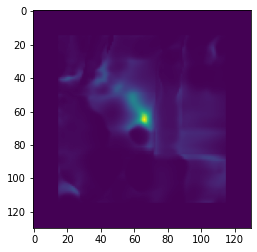

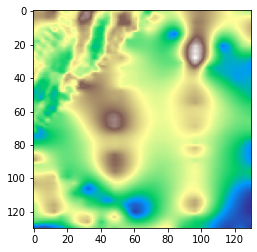

(1081, 985)
(1081, 986)
数据集最大长度为： 2135000
搜索长度： 10000
测试序号:1478598
输出向量尺寸：torch.Size([1, 208])
最小特征距离为：0.019
网格偏差距离：1.000
Groud Truth = (1081, 985)
Groud Truth id = 1478598
Center_Pred = (1081, 986)
Center_Pred id = 1478599


In [636]:
# %%time
rand_idx = int(torch.rand([1], dtype=torch.float32) * len(dataset_geo))
print("数据集最大长度为：" ,len(dataset_geo))
# rand_idx = 1844981
# rand_idx = 1569882
rand_idx = 1478598
print("测试序号:" + str(rand_idx))

data, data_global_norm, index, box =  dataset_geo.__getitem__(rand_idx)
# samples = samples.unsqueeze(0).cuda()
# data_global_norm = get_global_norm(samples)
# data = get_local_aug(samples)
data = data.unsqueeze(0).cuda(non_blocking=True)
data_global_norm = data_global_norm.unsqueeze(0).cuda(non_blocking=True)
output_vec = model(data, data_global_norm)
print("输出向量尺寸：" + str(output_vec.shape))

range_li = idx_ex_range(index, ex_range, n_rows, n_cols)
print("搜索长度：", len(range_li))

pre_index, min_dis, center_Pred, dis_array, range_data_array = matching_iter_for_simiPic(output_vec, range_li,  ex_range, n_rows, n_cols, (30,30))

# 计算像素偏差
center_Truth = idx2xy(int(index), n_rows, n_cols)
# center_Pred  = idx2xy(pre_index, n_rows, n_cols)
grid_bias = distance_point(center_Truth, center_Pred)

plt.imshow(dis_array.detach().numpy())
plt.savefig('./Distance_Vis/SSTM_Vis/SSTM_dis.tiff', dpi = 300)
plt.show()
plt.imshow(range_data_array.detach().numpy(), cmap="terrain")
plt.savefig('./Distance_Vis/SSTM_Vis/Terrain_range.tiff', dpi = 300)
plt.show()

store_to_file() # 打印到屏幕
log_file = open("./Distance_Vis/SSTM_Vis/SSTM_result.txt", 'w')
store_to_file(file=log_file) # 重定向到文件
log_file.close()

In [637]:
# dis_array[60, 64]
print(dis_array.max())
print(dis_array.min())
print(range_data_array.max())
print(range_data_array.min())

np.savetxt('./Distance_Vis/SSTM_Vis/SSTM_dis_array.csv',dis_array.detach().numpy(),fmt='%.5f',delimiter=',')
np.savetxt('./Distance_Vis/SSTM_Vis/SSTM_range_data_array.csv',range_data_array.detach().numpy(),fmt='%.5f',delimiter=',')
print("\n已保存到文件")

tensor(22026.4648, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>)
tensor(-5554.2319)
tensor(-5877.8169)

已保存到文件


In [ ]:
assert 0

# 【仿真】按照轨迹生成匹配位置

In [50]:
import numpy as np
from REF.LS_INS_GNSS_EKF.transform_functions import *

# 读取轨迹，转换为网格
trajectory_path = "./REF/LS_INS_GNSS_EKF/data_han/2023-08-05-21-18-41/"
gps_data = np.genfromtxt(trajectory_path + "ref_gps.csv", delimiter=',', skip_header=1)
meter_per_grid = 1# 定义1m是几个网格

lat_origin = np.deg2rad(28) # 中国东海位置，此处参数需要与轨迹保持一致
lon_origin = np.deg2rad(123.570504)
alt_origin = -100

NED_pos = np.zeros_like(gps_data[:, 0:3])
for i in range(gps_data.shape[0]):
    north, east, down = LLA_to_NED_SE(np.deg2rad(gps_data[i, 0]), np.deg2rad(gps_data[i, 1]), gps_data[i, 2], lat_origin, lon_origin, alt_origin)
    NED_pos[i] = north, east, down

# 
NED_pos_grid = np.around(NED_pos/meter_per_grid) # 根据尺度换算
NED_pos_grid_uni = np.unique(NED_pos_grid, axis=0).astype(int) # 去重，方便遍历匹配

/tmp/ipykernel_1324/3771125425.py:16: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  NED_pos[i] = north, east, down


In [51]:
def print_result(file = sys.stdout):
    print("总时长: " + str(total_time) + " s", file = file)
    print("测试时的增强："+ str(transform_for_match), file = file)
    print("测试时的全局增强："+ str(transform_for_global_match), file = file)
    try:
        print(Gauss_aug_Obj, file = file)
    except:
        pass
    print("测试地图：" + str(map_grid_path), file = file)
    print("随机测试数量：" + str(rand_test_num), file = file)
    print("crop_shape：" + str(crop_shape), file = file)
#     print("输入尺寸（网络）：" + str(out_shape), file = file)
    print("地图尺寸：" + str(z.shape), file = file)
#     print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test), file = file)
#     print("步长stride_test  =" + str(stride_test), file = file)
    print("save_file_path = " + str(save_file_path), file = file)
    print("pretrained_weights = " + str(args.pretrained_weights), file = file)
    print("num_ele_slice = " + str(args.num_ele_slice), file = file)
    print("arch = " + str(args.arch), file = file)
    print("先验范围 = " + str(ex_range), file = file)
    print("平均偏差 = " + "{:.5f}".format(avg_bias) + " grid", file = file)
    print("ACC_" + str(a) + " = " + "{:.2f}".format(acc_a*100) + "%", file = file)
    print("ACC_" + str(b) + " = " + "{:.2f}".format(acc_b*100) + "%", file = file)
    print("ACC_" + str(c) + " = " + "{:.2f}".format(acc_c*100) + "%", file = file)
    print("特征平均距离" + "{:.2f}".format(float(avg_Fea_Distance)), file = file)
    print("【ACC_li】从0-20 (step 0.5) 的偏差 " + str(Acc_li), file = file)

In [52]:
def write_to_temp(lines):
    with open('【临时】temp_log.txt', 'w') as f:
#         f = open('temp_log.txt', 'w')
        f.writelines(lines)
        f.close()

In [56]:
# 
a = 1 # 距离小于1个的准确率
b = 3
c = 10
ACC_range = 41

Acc_cnt_a  = 0
Acc_cnt_b  = 0
Acc_cnt_c  = 0
Acc_li = [0] * ACC_range

Bias_all = 0
dis_fea_all = 0
pdist = torch.nn.PairwiseDistance(p=2)
# t = tqdm(, ncols=80)
time_last = time.time()
# range_li = [i for i in range(dataset_geo.__len__())] # 获取先验范围
dataset_len = dataset_geo.__len__()

# select_li = np.random.choice(dataset_len, rand_test_num, replace=False)
# select_li = [int(item) for item in select_li] # 转为list
# print(select_li)
tra_match_result = np.zeros((NED_pos_grid_uni.shape[0], 4))
test_num = NED_pos_grid_uni.shape[0]
print("\r\n\r\n【按航迹匹配】测试数量：" + str(NED_pos_grid_uni.shape[0]) )
start_time = time.time()
for i, (north, east, _) in enumerate(NED_pos_grid_uni): # 遍历匹配 
    # 交换x，y的次序，因为NED和图的坐标系正好是xy相反的。下面的x，y仍代表图片的x，y
    y = north
    x = east
    torch.cuda.empty_cache()
    interval = time.time() - time_last
    time_last = time.time()
    eta = interval * (test_num - i )
    acc1_now = Acc_li[2] / (i+1) * 100
    str_log = "Processcing num: [" + str(i) +"/" + str(test_num) + "] "  + " Acc1_now=" + "{:0.2f}".format(acc1_now) + "% eta:" + str(int(eta//60))+ ":" + "{:02d}".format(int(eta%60)) + "          "
    print(str_log, end = '\r')
    write_to_temp(["Running 【NB16】按航迹匹配-匹配中……\n", str_log])
    
    center_i = x
    center_j = y
#     start_i = i * stride_test
#     start_j = j * stride_test
#     # 计算中心点坐标
#     center_i = start_i + shape[0] // 2
#     center_j = start_j + shape[1] // 2
#     # 转换为1步长的idx，便于检索
    idx_real = xy2idx(center_i, center_j, n_rows, n_cols, shape = crop_shape)
    # 对待匹配区域编码
    samples, samples_global_norm, index, box =  dataset_geo.__getitem__(idx_real)

    samples = samples.cuda().unsqueeze(0)
    samples_global_norm = samples_global_norm.cuda().unsqueeze(0)
    with torch.no_grad():
        output_vec = model(samples, samples_global_norm)
    # 匹配
#     index_ground     = dataset_geo.available_idx_li[index] # 获取idx_ground
    range_li = idx_ex_range(index, ex_range, n_rows, n_cols, shape = crop_shape) # 获取先验范围
    pre_index, min_fea_dis = matching_iter(output_vec, range_li)
#     pre_index_ground = dataset_geo.available_idx_li[pre_index] # 覆盖为idx_ground
#     pre_index[]
#     print("index=" + str(index))
#     print("pre_index=" + str(pre_index))
    # 计算像素偏差
#     center_Truth = idx2xy(index, n_rows, n_cols, shape = (224,224))
#     center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = (224,224))
    center_Truth = idx2xy(index, n_rows, n_cols, shape = crop_shape)
    center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = crop_shape)
    tra_match_result[i] = (center_Truth[0], center_Truth[1], center_Pred[0], center_Pred[1]) # 放入矩阵
    grid_bias = distance_point(center_Truth, center_Pred)
    # 计算特征偏差
    dis = pdist(output_vec, fea_vec_li[index, :].unsqueeze(0))
    for k in range(ACC_range):
        if grid_bias <= k / 2:
            Acc_li[k] += 1
    if grid_bias <= a: # 完全匹配计数
        Acc_cnt_a += 1
    if grid_bias <= b: # 完全匹配计数
        Acc_cnt_b += 1
    if grid_bias <= c: # 完全匹配计数
        Acc_cnt_c += 1 
    Bias_all += grid_bias
    dis_fea_all += dis
end_time = time.time()
total_time = end_time - start_time
print("\n处理完成")
avg_bias = Bias_all / test_num
acc_a = Acc_cnt_a / test_num
acc_b = Acc_cnt_b / test_num
acc_c = Acc_cnt_c / test_num
Acc_li = [acc / test_num for acc in Acc_li]

avg_Fea_Distance = dis_fea_all / test_num

print_result() # 默认参数打印到屏幕

log_file = open("【输出】NB16_match_result_temp_按航迹匹配.txt", 'w')
print_result(file=log_file) # 重定向到文件
log_file.close()



【按航迹匹配】测试数量：101
Processcing num: [100/101]  Acc1_now=58.42% eta:0:00          
处理完成
总时长: 59.48423361778259 s
测试时的增强：Compose(
    AddGaussianNoise(mean=0.00, variance=10.00, amplitude=1.00, p=1.00)
    AddPepperNoise(snr=0.999000, p=1.00)
    MuskApply(mask_size=224,target_size=224,mode=constant )
    ToTensor()
    Normalize(mean=[0.485], std=[0.229])
)
测试地图：./Matching_map_raw/太平洋1_grid.pth
随机测试数量：1000
crop_shape：(224, 224)
地图尺寸：(1623, 1748)
save_file_path = ./Matching_fea/太平洋1_GRET_ELE_DB_NO2_bi_fea.pth
pretrained_weights = ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth
num_ele_slice = 20000
arch = GRET_ELE_DB_NO2_bi
先验范围 = 50
平均偏差 = 2.89751 grid
ACC_1 = 59.41%
ACC_3 = 77.23%
ACC_10 = 87.13%
特征平均距离0.09
【ACC_li】从0-20 (step 0.5) 的偏差 [0.5643564356435643, 0.5643564356435643, 0.594059405940594, 0.594059405940594, 0.6039603960396039, 0.7722772277227723, 0.7722772277227723, 0.7821782178217822, 0.801980198019802, 0.8217821782178217, 0.8217821782178217, 0.8415841584158416, 0.8514

In [57]:
# 填充，使样本数一致
# tra_match_result = np.random.randn(NED_pos_grid_uni.shape[0], 4)
tra_match_result_repeat = np.zeros((NED_pos_grid.shape[0], 4))
for i, val in enumerate(tra_match_result):
    same_rows = np.all(NED_pos_grid == NED_pos_grid_uni[i], axis = 1) # 找到所有相同行
#     print(np.sum(same_rows==True))
    for row in np.where(same_rows==True): # 遍历赋值
        tra_match_result_repeat[row] = val

In [68]:
# 速度估计
from Py16_Navi import pos_estimate_vel, calculate_velocity
sample_num = tra_match_result_repeat.shape[0]
# 前三列是位置，后三列是速度
pos_vel_filtered = pos_estimate_vel(np.concatenate((tra_match_result_repeat[:,2:4], np.zeros((sample_num, 1))), axis=1), 0.01) # tra后两列是预测的位置

In [81]:
pos_3d = np.concatenate((tra_match_result_repeat[:,2:4], np.zeros((sample_num, 1))), axis=1)
np.array(calculate_velocity(pos_3d, 0.01)).shape

(999, 3)

In [75]:
tra_match_result_repeat[:,2:4].shape

(1000, 2)

In [66]:
# 转换为LLA坐标系
# 以上仍为图片的，xy坐标：转为LLA时仍需要交换x，y顺序，表示变为North、East顺序
# True_x, True_y, Pre_x, Pre_y
LLA_pos = np.zeros_like(gps_data[:, 0:3])
for i in range(LLA_pos.shape[0]):
    north = tra_match_result_repeat[i,1] * meter_per_grid # 位置不使用滤波后的，速度使用卡尔曼滤波后的
    east = tra_match_result_repeat[i,0] * meter_per_grid
    lat, lon, alt = NED_to_LLA_SE(north, east, 0, lat_origin, lon_origin, alt_origin)
    LLA_pos[i] = lat, lon, alt

# import shutil
# shutil.copy(trajectory_path + "gps_pos_lla.txt", trajectory_path + "【原始gps】gps_pos_lla.txt")
# shutil.copy(trajectory_path + "gps_vel_ned.txt", trajectory_path + "【原始gps】gps_vel_ned.txt")

# 文件输出
np.savetxt(trajectory_path + "gps_pos_lla.txt", LLA_pos, delimiter=',')
# np.savetxt(trajectory_path + "gps_vel_ned.txt", pos_vel_filtered[:, 3:6], delimiter=',') # 暂时不替换velocity的，因为速度估计暂时不准
# 备份删除gps数据
